In [8]:
from pathlib import Path

%matplotlib widget 
import matplotlib.pyplot as plt

import lightkurve as lk

from utility import iterate_targets
from utility import echo_analysis_log, parse_analysis_for_eclipses
from utility import flatten_lightcurve, plot_lightcurves_and_mask

In [9]:
# The following are good for clear primary & secondary eclipses and detrending through flattening;
# TIC141685465, TIC167692429, TIC307488184. TIC355152640, TIC382517745, TIC260132330

# TIC300560295 shows flattening removing pulsations but the secondary is not clear

# TIC308851582 looks like the analysis hasn't picked up the secondary correctly
# TIC341193555 - wrong secondary eclipse

# TIC350518984 has zero eclipse widths - also cannot see a secondary
# TIC372909935 has zero eclipse widths

# TIC031273263 - look into where the secondary is

# TIC309658221 - noisy but analysis should work

# TIC140659980 has good eclipses and potentially interesting residuals

# TIC167692429 - some variability in eclipse timings 
target = "TIC167692429"
flux_column = "pdcsap_flux"
quality_bitmask = "hardest"
sectors = []
eclipse_dur_multiple = 1.

input_file = Path(".") / "tessebs_extra.csv"
catalogue_dir = Path(".") / "catalogue"
analysis_dir = catalogue_dir / "analysis"
analysis_dir.mkdir(parents=True, exist_ok=True)

Analysis Log:
2024-03-15 23:00:25 INFO main_functions - analyse_light_curve: Start of analysis
2024-03-15 23:15:01 INFO main_functions - analyse_frequencies: Frequency extraction done. Total time elapsed: 875.9s.
2024-03-15 23:32:39 INFO main_functions - analyse_harmonics: Harmonic analysis done. Total time elapsed: 1058.5s.
2024-03-16 00:09:00 INFO main_functions - analyse_light_curve: End of analysis. Total time elapsed: 4115.6s.
From 167692429_analysis_summary.csv
Reference time:              1577.092143+/-0
Orbital period:              10.266468+/-0.000315
Eclipse times:               1587.141978+/-0.006007, 1591.851222+/-0.004250
Eclipse durations:           0.398935+/-0.012014, 0.442773+/-0.008499


Loaded 20 light curve fits file(s) for TIC167692429.

Processing sector 001...flattening the light curve...plotting the lightcurves.


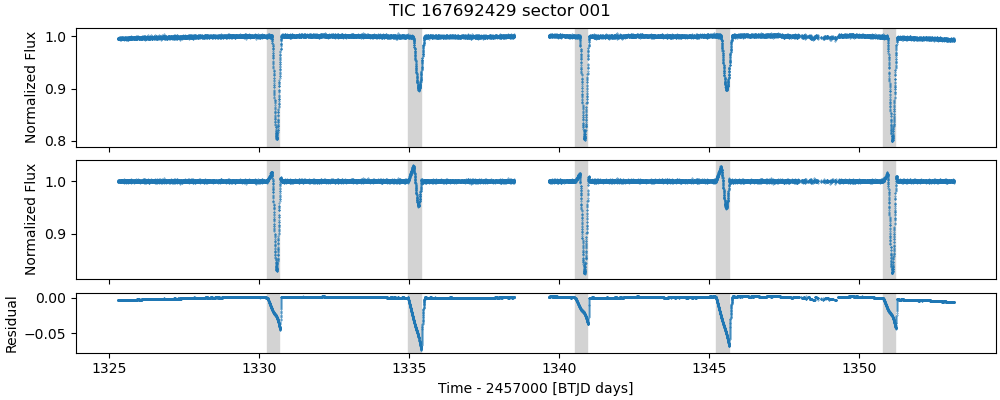


Processing sector 002...flattening the light curve...plotting the lightcurves.


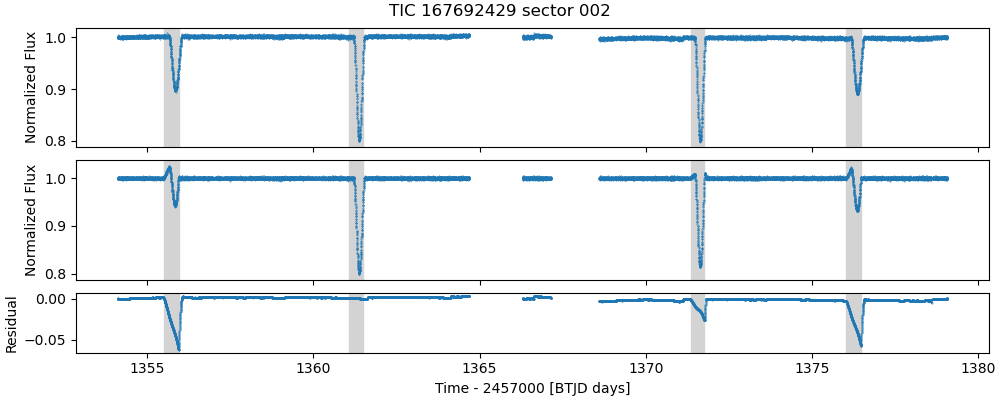


Processing sector 003...flattening the light curve...plotting the lightcurves.


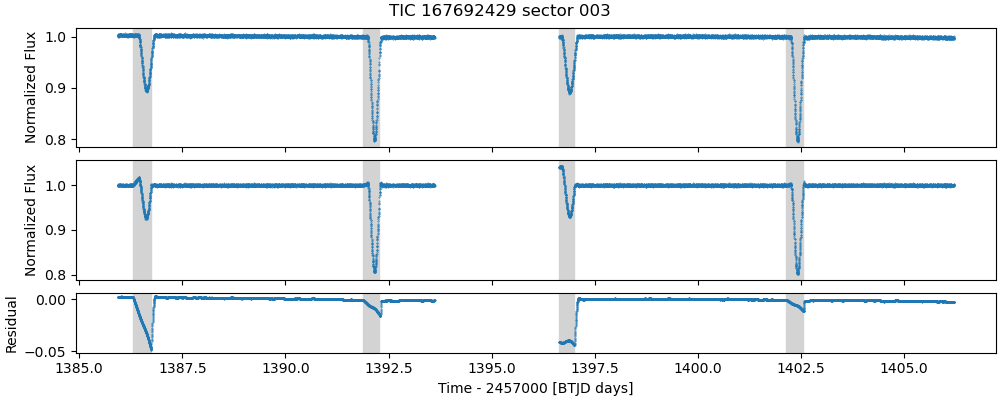


Processing sector 004...flattening the light curve...plotting the lightcurves.


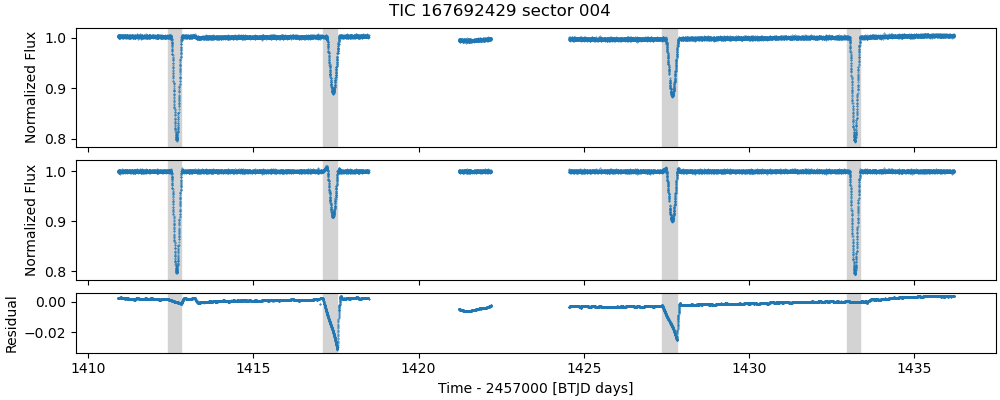


Processing sector 006...flattening the light curve...plotting the lightcurves.


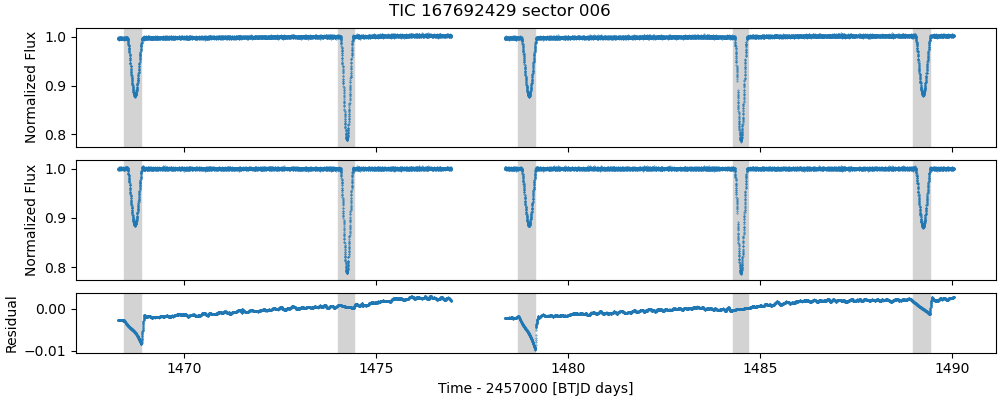


Processing sector 007...flattening the light curve...plotting the lightcurves.


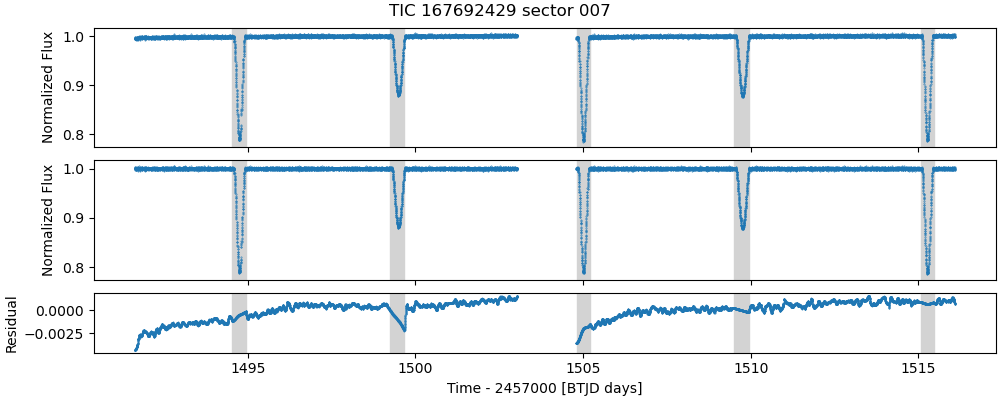


Processing sector 008...flattening the light curve...plotting the lightcurves.


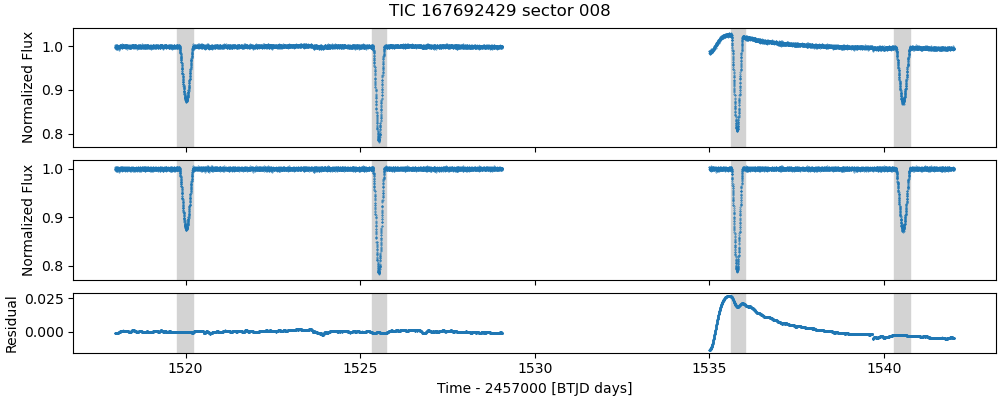


Processing sector 009...flattening the light curve...plotting the lightcurves.


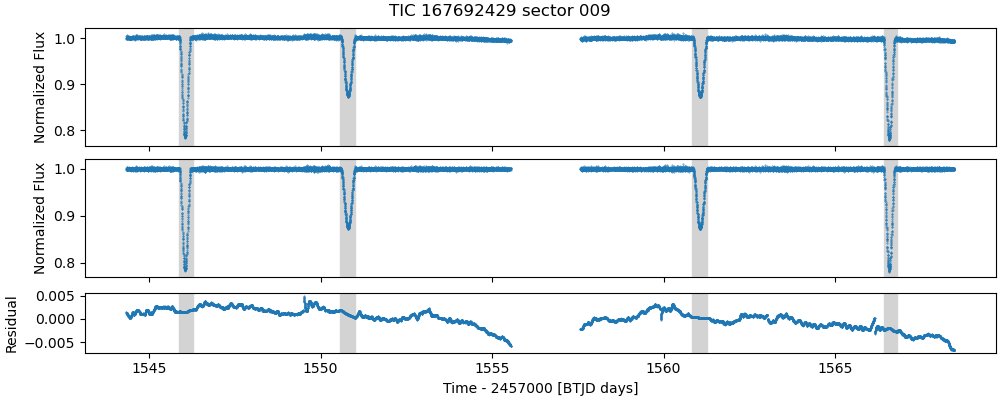


Processing sector 010...flattening the light curve...plotting the lightcurves.


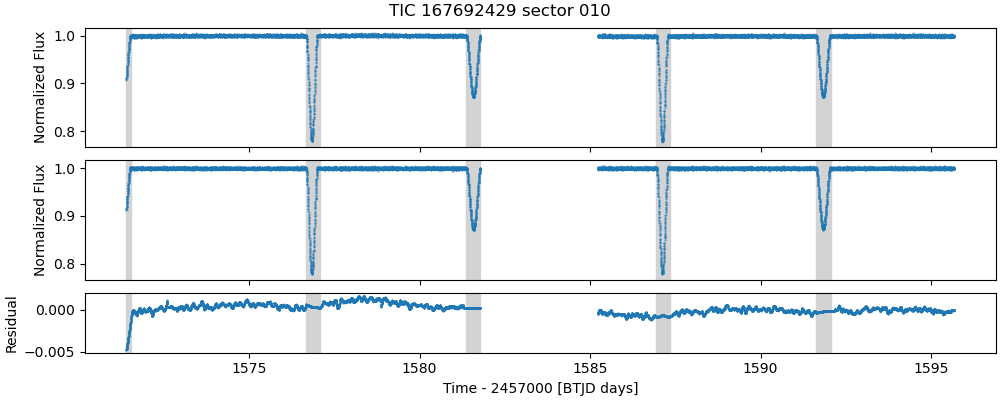


Processing sector 011...flattening the light curve...plotting the lightcurves.


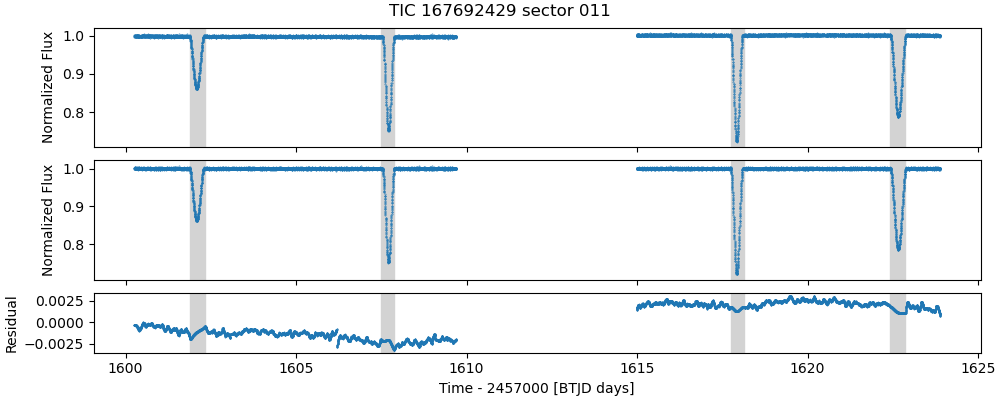


Processing sector 012...flattening the light curve...plotting the lightcurves.


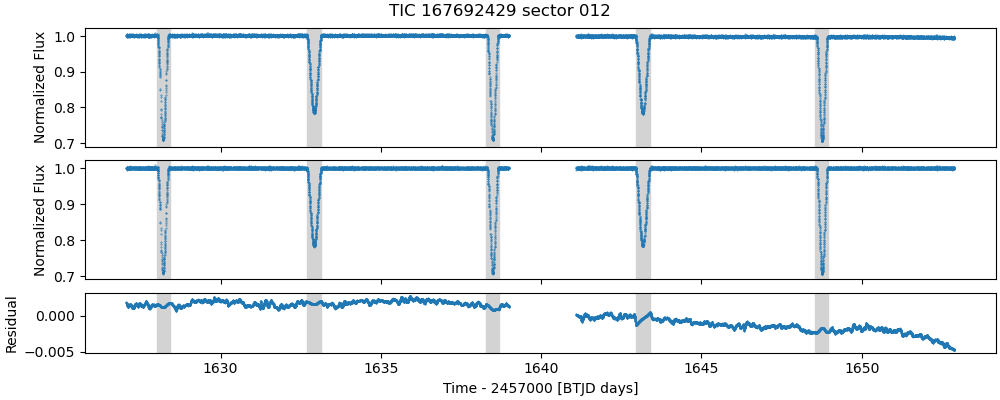


Processing sector 013...flattening the light curve...plotting the lightcurves.


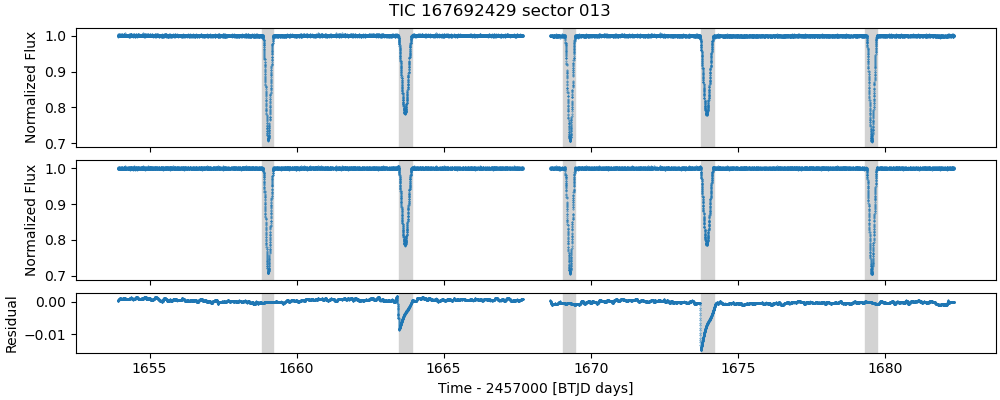


Processing sector 061...flattening the light curve...plotting the lightcurves.


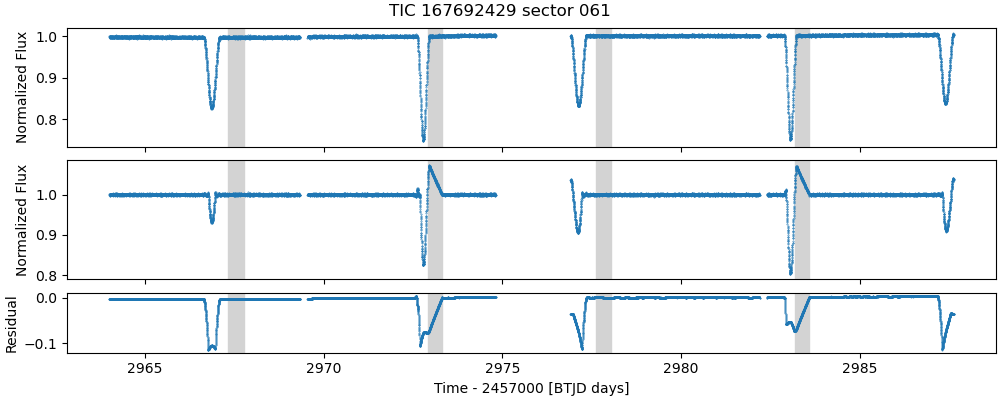


Processing sector 062...flattening the light curve...plotting the lightcurves.


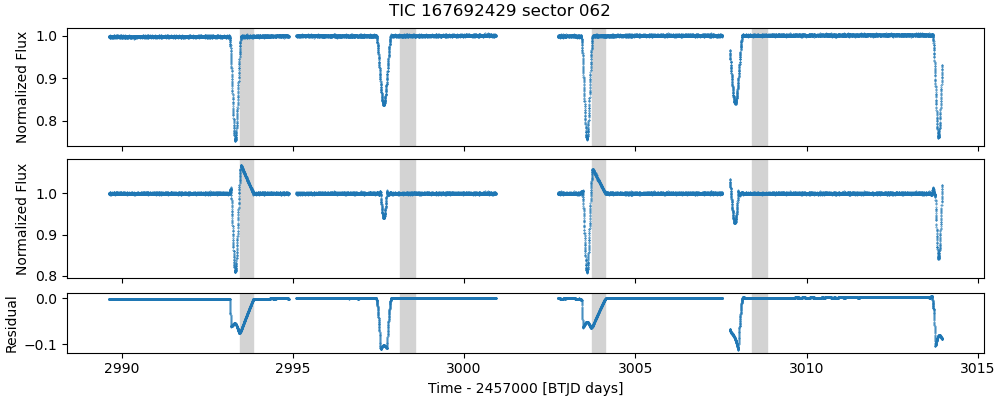


Processing sector 063...flattening the light curve...plotting the lightcurves.


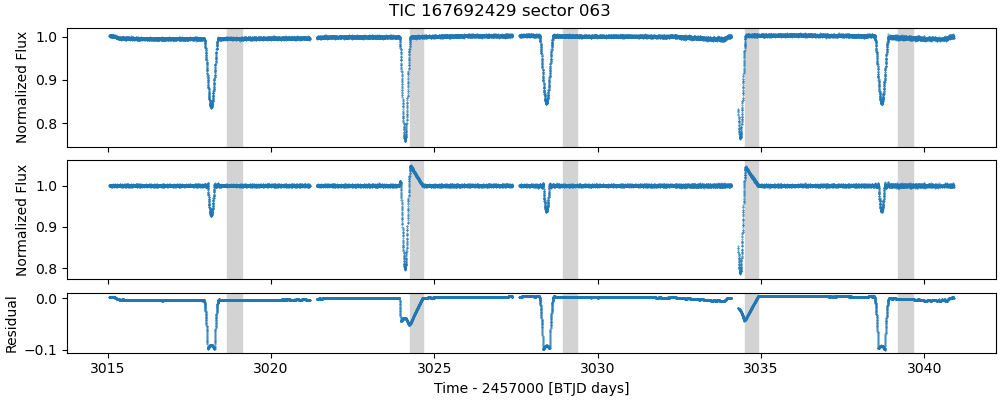


Processing sector 064...flattening the light curve...plotting the lightcurves.


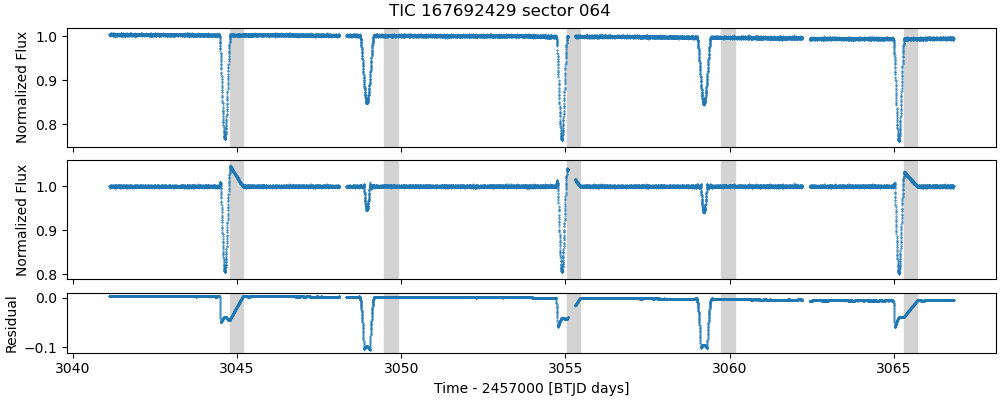


Processing sector 065...flattening the light curve...plotting the lightcurves.


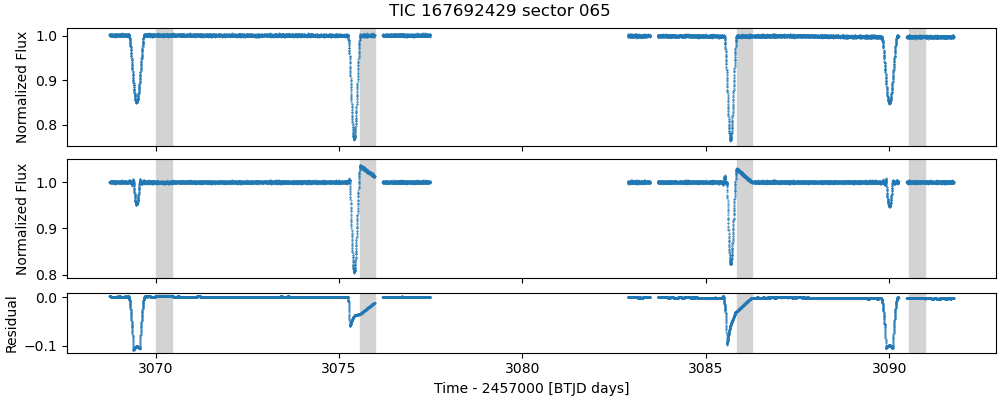


Processing sector 066...flattening the light curve...plotting the lightcurves.


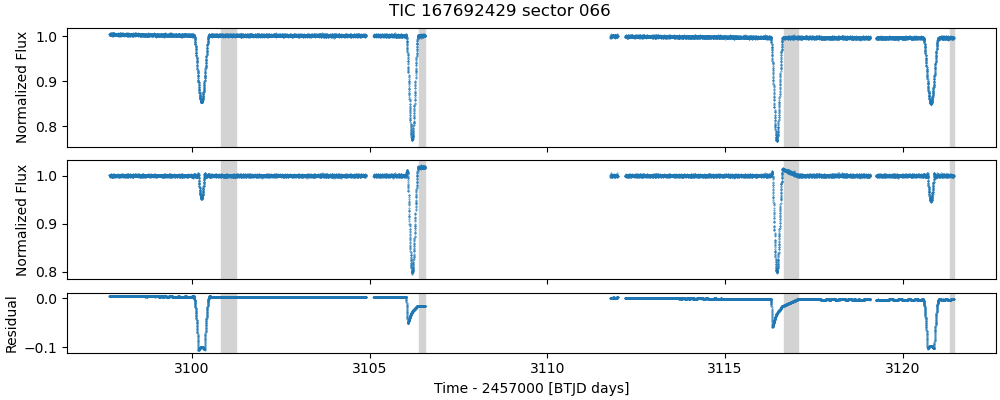


Processing sector 067...flattening the light curve...plotting the lightcurves.


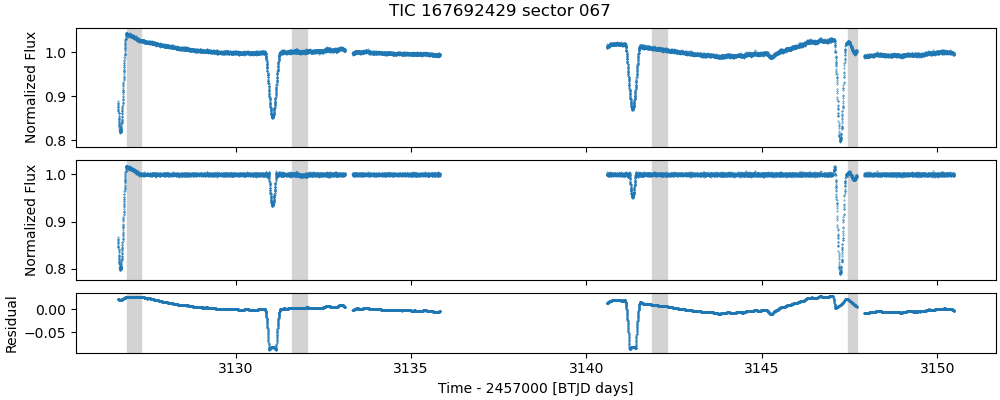


Processing sector 068...flattening the light curve...plotting the lightcurves.


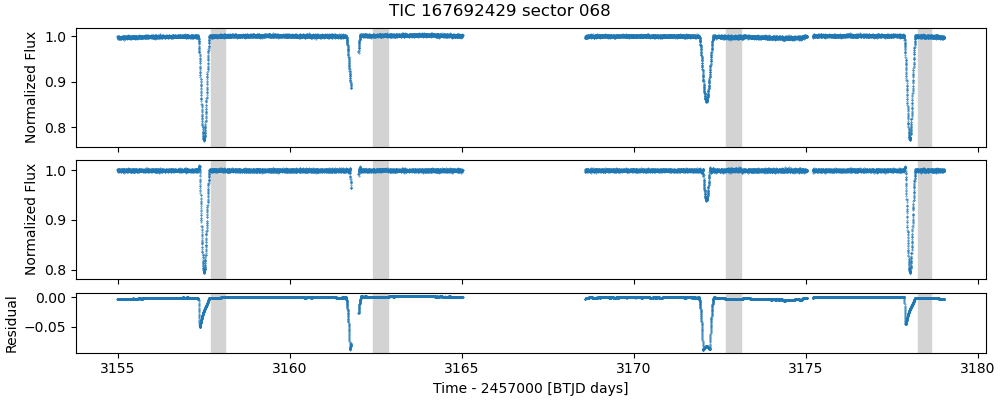

In [10]:
# Get the target's basic details. StopIteration will be raised if the target is unknown
target, target_row, _ = next(iterate_targets(input_file, index_filter=[target]))
tic = target_row["TIC"]

# We need the analysis output, as that contains the eclipse timing data
analysis_csv = analysis_dir / f"{tic}_analysis" / f"{tic}_analysis_summary.csv"
echo_analysis_log(analysis_csv.parent / f"{tic}.log")
eclipses = parse_analysis_for_eclipses(analysis_csv, duration_scale=eclipse_dur_multiple)
if not eclipses:
    print(f"Did not find '{analysis_csv}'. Unable to process {target}. Skipping.")
else:
    (t0, period, ecl_times, ecl_durs) = eclipses

    # Load, filter and then process the requested sectors for this target.
    target_dir = catalogue_dir / f"download/{tic:010d}/"
    fits = sorted(target_dir.rglob("**/*.fits"))
    lcs = lk.LightCurveCollection([
        lk.read(f"{f}", flux_column=flux_column, quality_bitmask=quality_bitmask) for f in fits])

    print(f"Loaded {len(lcs)} light curve fits file(s) for {target}.")
    for lc in [l for l in lcs if len(sectors) == 0 or l.sector in sectors]:
        print(f"\nProcessing sector {lc.sector:03d}...", end="")

        # Process the light curve
        print("flattening the light curve...", end="")
        lc = lc.normalize()
        flat_lc, res_lc, ecl_mask = flatten_lightcurve(lc, ecl_times, ecl_durs, period)

        # Plots
        print("plotting the lightcurves.")
        title = f"{lc.meta['OBJECT']} sector {lc.sector:03d}"
        fig, _ = plot_lightcurves_and_mask(lc, flat_lc, res_lc, ecl_mask, (10, 4), title)
        plt.show(block=False)